In [1]:
# David Ouyang 12/5/2019

# Notebook which:
# 1. Downloads weights
# 2. Initializes model and imports weights
# 3. Performs test time evaluation of videos (already preprocessed with ConvertDICOMToAVI.ipynb)

import re
import os, os.path
from os.path import splitext
import pydicom as dicom
import numpy as np
from pydicom.uid import UID, generate_uid
import shutil
from multiprocessing import dummy as multiprocessing
import time
import subprocess
import datetime
from datetime import date
import sys
import cv2
import matplotlib.pyplot as plt
import sys
from shutil import copy
import math
import torch
import torchvision
import pathlib
import tqdm
import scipy 
from sklearn.metrics import mean_squared_error,r2_score
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM
%matplotlib widget

import skimage
import pandas as pd

sys.path.append("..")
import echonet

import wget 

#destinationFolder = "/Users/davidouyang/Dropbox/Echo Research/CodeBase/Output"
destinationFolder = "/athena/sablab/scratch/prj4005/Outputs/scrath_ef"

#videosFolder = "/Users/davidouyang/Dropbox/Echo Research/CodeBase/a4c-video-dir"
videosFolder = "/athena/sablab/scratch/dataset/echonet/Videos"
#DestinationForWeights = "/Users/davidouyang/Dropbox/Echo Research/CodeBase/EchoNetDynamic-Weights"
DestinationForWeights = "/athena/sablab/scratch/prj4005/Echonet/dynamic/weights"

In [97]:
# Initialize and Run EF model

frames = 32
period = 1 #2
batch_size = 20
model = torchvision.models.video.r2plus1d_18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 1)



print("loading weights from ", '/athena/sablab/scratch/prj4005/Outputs/scrath_ef/best.pt')

if torch.cuda.is_available():
    print("cuda is available, original weights")
    device = torch.device("cuda")
    model = torch.nn.DataParallel(model)
    model.to(device)
    checkpoint = torch.load('/athena/sablab/scratch/prj4005/Outputs/scrath_ef/best.pt')
    model.load_state_dict(checkpoint['state_dict'])
else:
    print("cuda is not available, cpu weights")
    device = torch.device("cpu")
    checkpoint = torch.load('/athena/sablab/scratch/prj4005/Outputs/scrath_ef/best.pt', map_location = "cpu")
    state_dict_cpu = {k[7:]: v for (k, v) in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict_cpu)

loading weights from  /athena/sablab/scratch/prj4005/Outputs/scrath_ef/best.pt
cuda is available, original weights


In [2]:
device = torch.device("cuda")

In [44]:
ds = echonet.datasets.Echo(split = "external_test", external_test_location = videosFolder)
print(ds.split, ds.fnames)
mean, std = echonet.utils.get_mean_and_std(ds)
kwargs = {"target_type": "EF",
          "mean": mean,
          "std": std,
          "length": frames,
          "period": period,
          }

ds = echonet.datasets.Echo(split = "external_test", external_test_location = videosFolder, **kwargs)
test_dataloader = torch.utils.data.DataLoader(ds, batch_size = 1, num_workers = 5, shuffle = False, pin_memory=(device.type == "cuda"))

model.eval()
model.to(device)



  0%|          | 0/16 [00:00<?, ?it/s]

EXTERNAL_TEST ['0X100009310A3BD7FC.avi', '0X1002E8FBACD08477.avi', '0X1005D03EED19C65B.avi', '0X10075961BC11C88E.avi', '0X10094BA0A028EAC3.avi', '0X100CF05D141FF143.avi', '0X100E3B8D3280BEC5.avi', '0X100E491B3CD58DE2.avi', '0X100F044876B98F90.avi', '0X101026B90DAE7E95.avi', '0X1012703CDC1436FE.avi', '0X1013E8A4864781B.avi', '0X1018521A3BC5CDBA.avi', '0X101C388397F66EDB.avi', '0X101CFC9C5351DCBE.avi', '0X101E654AF3FC07A8.avi', '0X10267ADF2E644E0.avi', '0X102AE9C68B2C46DA.avi', '0X102C51641C321436.avi', '0X102CFB07F752AAE6.avi', '0X102DD1B9BE03716.avi', '0X102E453603FA1440.avi', '0X102E94908346DE1D.avi', '0X102F3D4CD5E10801.avi', '0X10365E52F01510B4.avi', '0X1039108E17193B1C.avi', '0X1039B49145DF4F25.avi', '0X103A55B2546EF36E.avi', '0X103BE163257D663A.avi', '0X1040C376CF369A01.avi', '0X1040D64234D3E916.avi', '0X1043D3D352972862.avi', '0X1045F1B5A0A5EA54.avi', '0X104D2C3D60AE3DE8.avi', '0X105039B849CDB1CD.avi', '0X10516E63208D8EA1.avi', '0X1055D6B76E5D7556.avi', '0X10569E00E4DFFF7D.avi', 

100%|██████████| 16/16 [00:07<00:00,  2.19it/s]


DataParallel(
  (module): VideoResNet(
    (stem): R2Plus1dStem(
      (0): Conv3d(3, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
      (1): BatchNorm3d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(45, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
      (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Sequential(
          (0): Conv2Plus1D(
            (0): Conv3d(64, 144, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
            (1): BatchNorm3d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv3d(144, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
          )
          (1): BatchNorm3d(64,

In [94]:
model.eval()
print(model.module.layer1[1])
print(model.module.layer1[0])


BasicBlock(
  (conv1): Sequential(
    (0): Conv2Plus1D(
      (0): Conv3d(64, 144, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
      (1): BatchNorm3d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(144, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
    )
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2Plus1D(
      (0): Conv3d(64, 144, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
      (1): BatchNorm3d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(144, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
    )
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (relu): ReLU(inplace=True)
)
B

In [6]:
data = next(iter(test_dataloader))

In [8]:
print(len(data))
print(data[0].shape)
print(data[1].shape)

2
torch.Size([1, 3, 32, 112, 112])
torch.Size([1])


In [9]:
pred = model(data[0].to(device))


In [98]:
# a dict to store the activations
activation = {}
def getActivation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

gradients  = {}
def getGradients(name):
    def hook(model, input, output):
        gradients[name] = output
    return hook


In [99]:

h0=model.module.layer4[0].relu.register_forward_hook(getActivation('layer0'))
g0=model.module.layer4[0].relu.register_backward_hook(getGradients('layer0'))

h1=model.module.layer4[1].relu.register_forward_hook(getActivation('layer1'))
g1=model.module.layer4[1].relu.register_backward_hook(getGradients('layer1'))

In [101]:
pred = model(data[0].to(device))
pred.backward(retain_graph=True)

/home/prj4005/.conda/envs/echo/lib/python3.9/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [96]:
h1.remove()
g1.remove()

In [106]:
print(activation['layer1'].shape)

torch.Size([1, 512, 4, 7, 7])


In [107]:
print(gradients['layer1'][0].shape)

torch.Size([1, 512, 4, 7, 7])


In [102]:
pooled_gradients = torch.mean(gradients['layer1'][0], dim=[0, 2, 3])
channels,n_frames = activation['layer1'].shape[1],activation['layer1'].shape[2]
for i in range(channels):
    for j in range(n_frames):
        activation['layer1'][0, i, j, :, :] *= pooled_gradients[i,j]

heatmap = torch.mean(activation['layer1'], dim=1).squeeze()
heatmap = heatmap.cpu().numpy()
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)



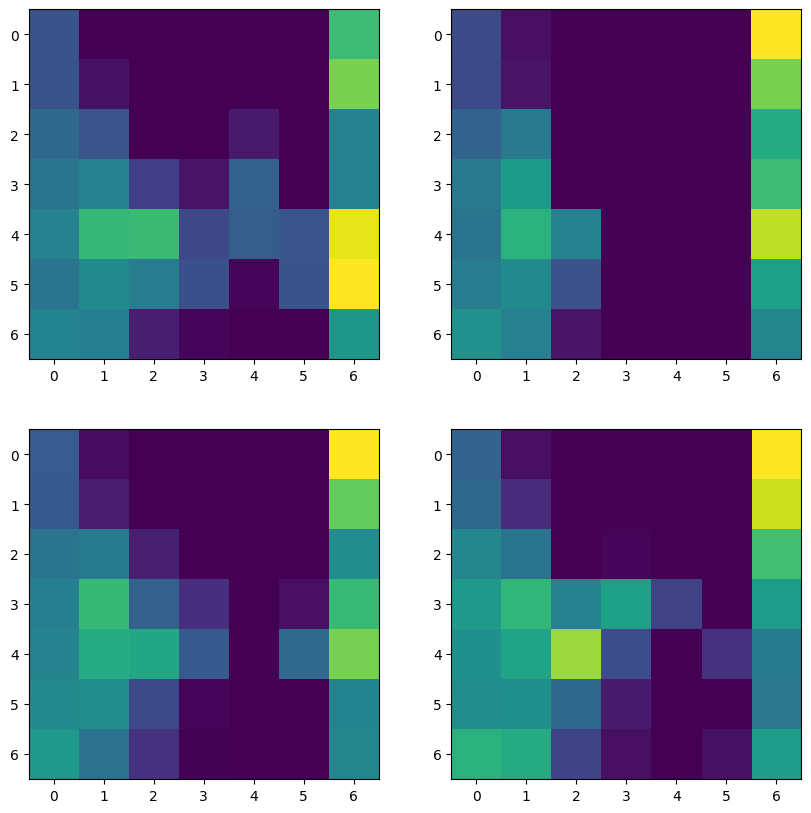

In [103]:
%matplotlib inline

plt.figure(figsize=(10,10))
for ii, _ in enumerate(range(0,n_frames)):
    plt.subplot(2,2,ii+1)
    plt.imshow(heatmap[ii])
#     plt.title(idx_to_label_dict[label.item()])

In [104]:
pooled_gradients = torch.mean(gradients['layer0'][0], dim=[0, 2, 3])
channels,n_frames = activation['layer0'].shape[1],activation['layer0'].shape[2]
for i in range(channels):
    for j in range(n_frames):
        activation['layer0'][0, i, j, :, :] *= pooled_gradients[i,j]

heatmap = torch.mean(activation['layer0'], dim=1).squeeze()
heatmap = heatmap.cpu().numpy()
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

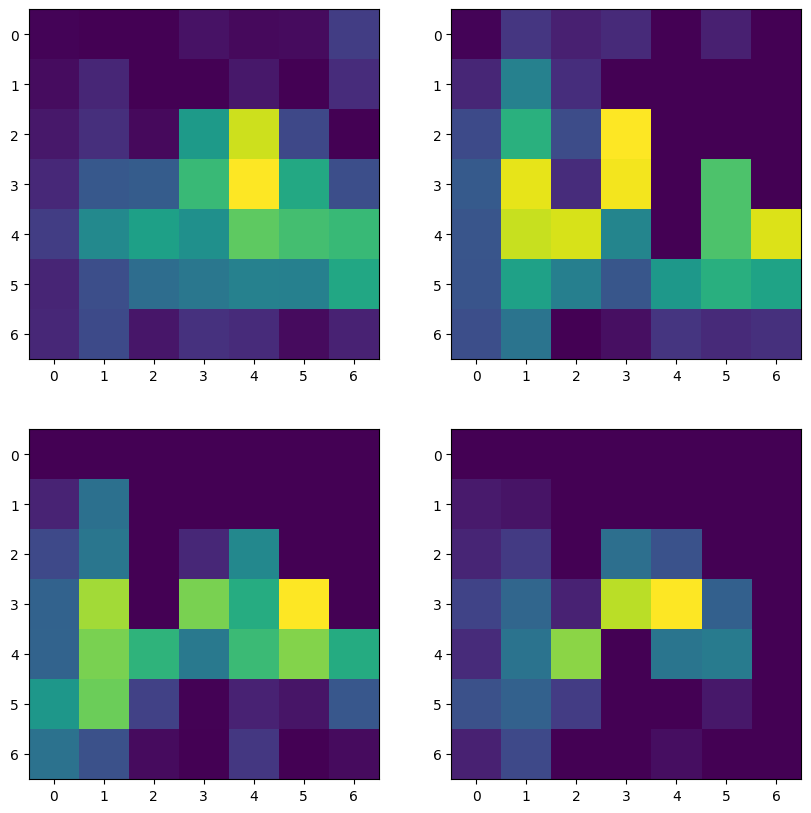

In [105]:
%matplotlib inline

plt.figure(figsize=(10,10))
for ii, _ in enumerate(range(0,n_frames)):
    plt.subplot(2,2,ii+1)
    plt.imshow(heatmap[ii])
#     plt.title(idx_to_label_dict[label.item()])

In [3]:
output = os.path.join(destinationFolder, "scratch_ef.csv")

ds = echonet.datasets.Echo(split = "external_test", external_test_location = videosFolder)
print(ds.split, ds.fnames)

mean, std = echonet.utils.get_mean_and_std(ds)

kwargs = {"target_type": "EF",
          "mean": mean,
          "std": std,
          "length": frames,
          "period": period,
          }

ds = echonet.datasets.Echo(split = "external_test", external_test_location = videosFolder, **kwargs)

test_dataloader = torch.utils.data.DataLoader(ds, batch_size = 1, num_workers = 5, shuffle = False, pin_memory=(device.type == "cuda"))
loss, yhat, y = echonet.utils.video.run_epoch(model, test_dataloader,False, None, device, save_all=True)

with open(output, "w") as g:
    for (filename, pred) in zip(ds.fnames, yhat):
        for (i,p) in enumerate(pred):
            g.write("{},{},{:.4f}\n".format(filename, i, p))


loading weights from  /athena/sablab/scratch/prj4005/Outputs/scrath_ef/best.pt
cuda is available, original weights


  0%|          | 0/16 [00:00<?, ?it/s]

EXTERNAL_TEST ['0X100009310A3BD7FC.avi', '0X1002E8FBACD08477.avi', '0X1005D03EED19C65B.avi', '0X10075961BC11C88E.avi', '0X10094BA0A028EAC3.avi', '0X100CF05D141FF143.avi', '0X100E3B8D3280BEC5.avi', '0X100E491B3CD58DE2.avi', '0X100F044876B98F90.avi', '0X101026B90DAE7E95.avi', '0X1012703CDC1436FE.avi', '0X1013E8A4864781B.avi', '0X1018521A3BC5CDBA.avi', '0X101C388397F66EDB.avi', '0X101CFC9C5351DCBE.avi', '0X101E654AF3FC07A8.avi', '0X10267ADF2E644E0.avi', '0X102AE9C68B2C46DA.avi', '0X102C51641C321436.avi', '0X102CFB07F752AAE6.avi', '0X102DD1B9BE03716.avi', '0X102E453603FA1440.avi', '0X102E94908346DE1D.avi', '0X102F3D4CD5E10801.avi', '0X10365E52F01510B4.avi', '0X1039108E17193B1C.avi', '0X1039B49145DF4F25.avi', '0X103A55B2546EF36E.avi', '0X103BE163257D663A.avi', '0X1040C376CF369A01.avi', '0X1040D64234D3E916.avi', '0X1043D3D352972862.avi', '0X1045F1B5A0A5EA54.avi', '0X104D2C3D60AE3DE8.avi', '0X105039B849CDB1CD.avi', '0X10516E63208D8EA1.avi', '0X1055D6B76E5D7556.avi', '0X10569E00E4DFFF7D.avi', 

100%|██████████| 10030/10030 [10:03<00:00, 16.63it/s, 0.00 (0.00) / 0.00]


In [3]:
output = os.path.join(destinationFolder, "pretrained_ef.csv")


In [ ]:
with open(output, "w+") as g:
    for (filename, pred) in zip(ds.fnames, yhat):
        for (i,p) in enumerate(pred):
            g.write("{},{},{:.4f}\n".format(filename, i, p))


In [ ]:
from IPython.display import display_pdf
filename = "/athena/sablab/scratch/prj4005/Outputs/size/0X105B9EF57DE45DCB.pdf"
with open(filename,"rb") as f:
    display_pdf(f.read(),raw=True)


In [4]:
Raw_data = pd.read_csv('/athena/sablab/scratch/dataset/echonet/FileList.csv', delimiter=',')
Output_data = pd.read_csv(output,header= None, names = ['FileName','FrameNumber','EF'])

In [19]:
Raw_data.head()

,FileName,EF,ESV,EDV,FrameHeight,FrameWidth,FPS,NumberOfFrames,Split
0,0X100009310A3BD7FC,78.498406,14.881368,69.210534,112,112,50,174,VAL
1,0X1002E8FBACD08477,59.101988,40.383876,98.742884,112,112,50,215,TRAIN
2,0X1005D03EED19C65B,62.363798,14.267784,37.909734,112,112,50,104,TRAIN
3,0X10075961BC11C88E,54.545097,33.143084,72.914210,112,112,55,122,TRAIN
4,0X10094BA0A028EAC3,24.887742,127.581945,169.855024,112,112,52,207,VAL


In [5]:
Output_data['FileName'] = Output_data['FileName'].str.replace('.avi','')
Output_data.head()


/tmp/ipykernel_156801/3298919079.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  Output_data['FileName'] = Output_data['FileName'].str.replace('.avi','')


,FileName,FrameNumber,EF
0,0X100009310A3BD7FC,0,67.5333
1,0X1002E8FBACD08477,0,48.6000
2,0X1005D03EED19C65B,0,61.0651
3,0X10075961BC11C88E,0,49.2817
4,0X10094BA0A028EAC3,0,16.0578


In [6]:
Combined_df = Raw_data.merge(Output_data, on = 'FileName')
Combined_train = Combined_df[Combined_df['Split'] == 'TRAIN']
Combined_val = Combined_df[Combined_df['Split'] == 'VAL']
Combined_test = Combined_df[Combined_df['Split'] == 'TEST']

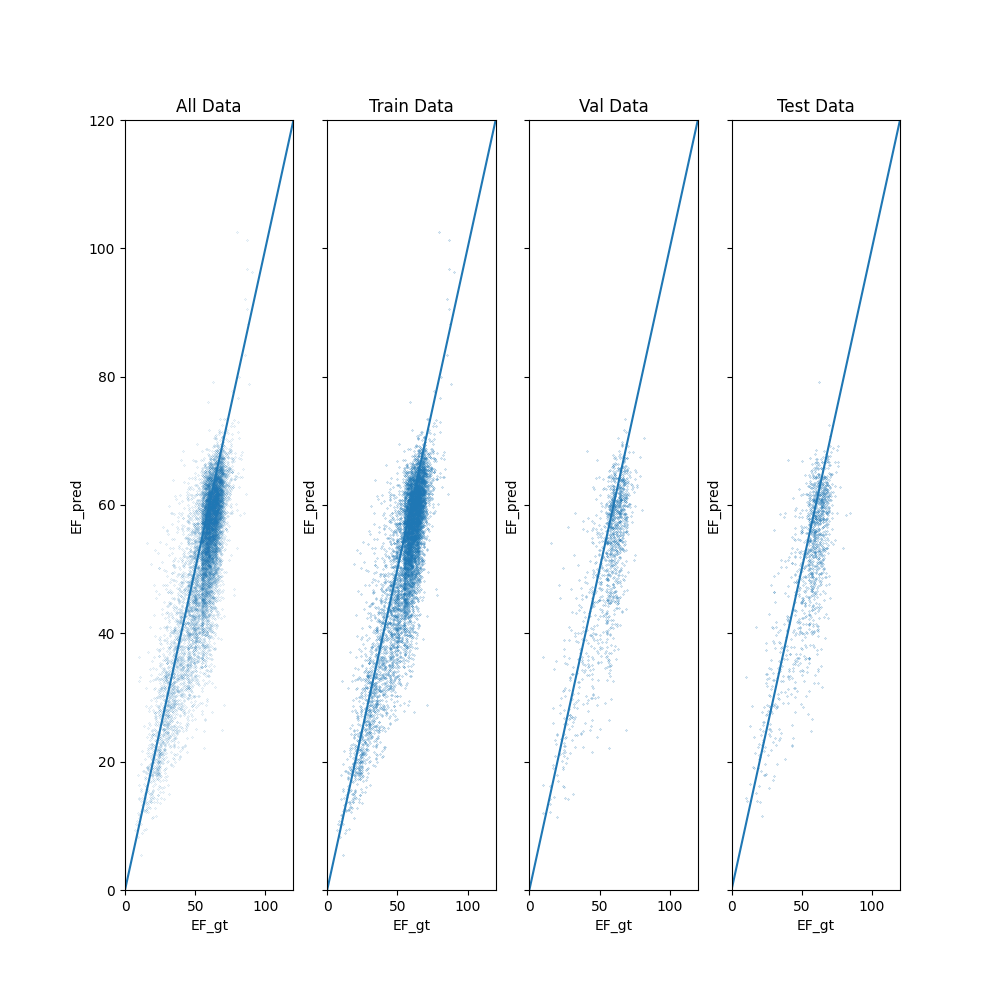

In [11]:
fig,ax = plt.subplots(1,4,sharex=True,sharey=True,figsize=(10,10))
ax[0].plot(Combined_df['EF_x'],Combined_df['EF_y'],'o',markersize=0.1)
ax[0].set_xlim(0,120)
ax[0].set_ylim(0,120)
ax[0].set_xlabel('EF_gt')
ax[0].set_ylabel('EF_pred')
ax[0].set_title('All Data')
ax[0].axline((0, 0), slope=1)
ax[1].plot(Combined_train['EF_x'],Combined_train['EF_y'],'o',markersize=0.2)
ax[1].set_xlabel('EF_gt')
ax[1].set_ylabel('EF_pred')
ax[1].set_title('Train Data')
ax[1].axline((0, 0), slope=1)
ax[2].plot(Combined_val['EF_x'],Combined_val['EF_y'],'o',markersize=0.2)
ax[2].set_xlabel('EF_gt')
ax[2].set_ylabel('EF_pred')
ax[2].set_title('Val Data')
ax[2].axline((0, 0), slope=1)
ax[3].plot(Combined_test['EF_x'],Combined_test['EF_y'],'o',markersize=0.2)
ax[3].set_xlabel('EF_gt')
ax[3].set_ylabel('EF_pred')
ax[3].set_title('Test Data')
ax[3].axline((0, 0), slope=1)

In [11]:
mse = mean_squared_error(Combined_df['EF_x'],Combined_df['EF_y'])
mse_train = mean_squared_error(Combined_train['EF_x'],Combined_train['EF_y'])
mse_test = mean_squared_error(Combined_test['EF_x'],Combined_test['EF_y'])
mse_val = mean_squared_error(Combined_val['EF_x'],Combined_val['EF_y'])


In [16]:
print('MSE for all data is: ', np.sqrt(mse))
print('MSE for train data is: ', np.sqrt(mse_train))
print('MSE for test data is: ', np.sqrt(mse_test))
print('MSE for val data is: ', np.sqrt(mse_val))


MSE for all data is:  8.189302129466185
MSE for train data is:  7.851648310453738
MSE for test data is:  8.98545336846128
MSE for val data is:  9.21409292338703


In [17]:
r_squared = r2_score(Combined_df['EF_x'],Combined_df['EF_y'])
r_squared_train = r2_score(Combined_train['EF_x'],Combined_train['EF_y'])
r_squared_test = r2_score(Combined_test['EF_x'],Combined_test['EF_y'])
r_squared_val = r2_score(Combined_val['EF_x'],Combined_val['EF_y'])
r = np.sqrt(r_squared)
r_train = np.sqrt(r_squared_train)
r_test = np.sqrt(r_squared_test)
r_val = np.sqrt(r_squared_val)


In [18]:
print('R2 for all data is: ', r_squared)
print('R2 for train data is: ', r_squared_train)
print('R2 for test data is: ', r_squared_test)
print('R2 for val data is: ', r_squared_val)
print('R for all data is: ', r)
print('R for train data is: ', r_train)
print('R for test data is: ', r_test)
print('R for val data is: ', r_val)


R2 for all data is:  0.5617785925081644
R2 for train data is:  0.5994718725790356
R2 for test data is:  0.45980908166389045
R2 for val data is:  0.43929036068619687
R for all data is:  0.7495189073720319
R for train data is:  0.7742556894069527
R for test data is:  0.6780922368408965
R for val data is:  0.6627898314595637
